In [73]:
import pandas as pd
import numpy as np
import importlib
import time


In [2]:
import disall

In [76]:
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import CrossValidationEstimator

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
importlib.reload(disall)

<module 'disall' (<_frozen_importlib_external._NamespaceLoader object at 0x1472330e2e90>)>

In [83]:
from disall.ce_parsing import parse_to_icet_relaxer, filter_strain
from disall.enumerate import structures_pool
from disall.quick_plot import parity_plot

In [7]:
df = pd.read_pickle('data_protocol4.pkl', )

In [8]:
df = df[~df['chgnet'].isnull()]
df

,init_structure,size,chgnet
0,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Al', [0.0, 0.0, 0.0], index=0)), -3.30..."
1,"(Atom('Co', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Co', [0.0, 0.0, 0.0], index=0)), -6.93..."
2,"(Atom('Cr', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Cr', [0.0, 0.0, 0.0], index=0)), -9.11..."
3,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Cu', [0.0, 0.0, 0.0], index=0)), -3.97..."
4,"(Atom('Fe', [0.0, 0.0, 0.0], index=0))",1,"((Atom('Fe', [0.0, 0.0, 0.0], index=0)), -8.18..."
...,...,...,...
24995,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-5.6944767655819984e-08, 6.82886..."
24996,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-8.037595437119736e-08, -1.77951..."
24997,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-2.4783974815253773e-07, -1.2455..."
24998,"(Atom('Co', [0.0, 0.0, 0.0], index=0), Atom('F...",6,"((Atom('Co', [-2.8099467769636366e-08, -3.6403..."


In [67]:
relax_chgnet_df, prim, constant_a0, elements = parse_to_icet_relaxer(df, 'chgnet')
work_df = filter_strain(relax_chgnet_df, 0.05)

In [68]:
elements

['Al', 'Co', 'Cr', 'Cu', 'Fe', 'Mn', 'Ni', 'V']

In [71]:
cs_fcc = ClusterSpace(structure=prim, cutoffs=[constant_a0*2.5, constant_a0*1.3, constant_a0*0.72],
                  chemical_symbols=[elements])
sc_fcc = StructureContainer(cs_fcc)

In [74]:
ti = time.time()
df_work.apply(lambda x: sc_fcc.add_structure(x['init_structure'],
    properties={'mix_energy': x['energy_reference'],}
                                               ), axis=1)
print('{}s'.format(time.time() - ti))

351.26698899269104s


In [77]:
opt_meg = CrossValidationEstimator(sc_fcc.get_fit_data(key='mix_energy'),
                                   n_splits=10, fit_method='ardr')

In [78]:
# ardr
opt_meg.validate()
print(opt_meg.R2_validation)
print(opt_meg.rmse_validation)
print(opt_meg.n_nonzero_parameters_splits)
print(opt_meg.rmse_validation_splits)

/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.520829953512933e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.622603810024093e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.2432395806636662e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')
/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.3529274737295557e+17
  warnings.wa

0.9913286092585738
0.012636673047991615
[111 109 112 105 104 113 117 106 113 114]
[0.01322488 0.01243038 0.01222181 0.01330928 0.01253073 0.01274044
 0.01264823 0.01266398 0.0124311  0.01216589]


In [92]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
def set_font(plt, font_dir = '/scratch/group/arroyave_lab/guillermo.vazquez/FONTS/erewhon-math'):
    plt.rcParams.update({'font.size': 15})
    
    plt.rc('mathtext', fontset="cm")
    
    font_dirs = [font_dir]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    
    # set font
    plt.rcParams['font.family'] = 'Erewhon Math'
set_font(plt)

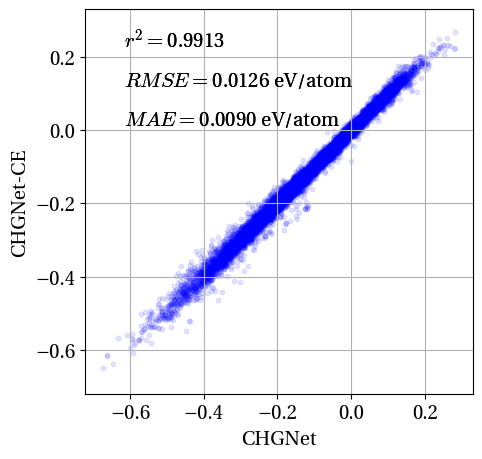

In [94]:
parity_plot([[opt_meg.scatter_data_validation.target, opt_meg.scatter_data_validation.predicted]],alpha=0.1, s=10,
            unit= ' eV/atom', xlabel='CHGNet', ylabel='CHGNet-CE')

In [96]:
opt_meg.train()
ce_ = ClusterExpansion(cs_fcc, opt_meg.parameters)

/scratch/group/arroyave_lab/guillermo.vazquez/conda_envs/alloy_env/lib/python3.10/site-packages/trainstation/fit_methods.py:80: UserWarning: Warning: Condition number is large, 1.429216784812605e+17
  warnings.warn(f'Warning: Condition number is large, {cond}')


(-0.00812796745925154, 0.018402154005001586)

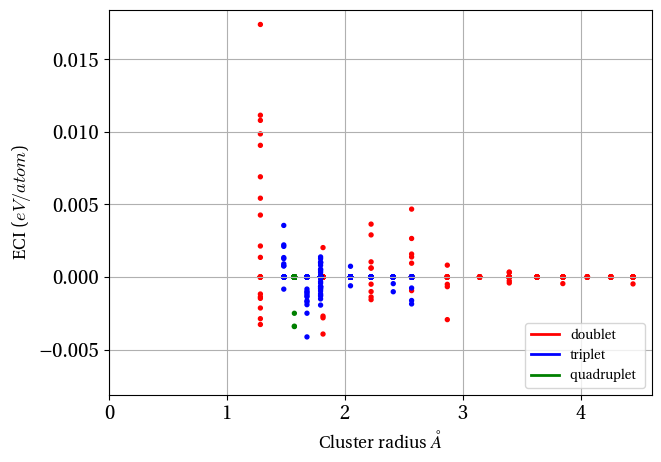

In [107]:
df_ce = ce_.to_dataframe()
df_ce['size'] = df_ce['multicomponent_vector'].apply(lambda x: len(x))
df_plot = df_ce[df_ce['size']>1]

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.grid(True)
axs.scatter(df_plot['radius'].values, 
            df_plot['eci'].values, 
            color= df_plot['size'].apply(lambda x: ['r','b','g'][x-2]).tolist(),
       s = 8)


custom_legend = [plt.Line2D([0], [0], color=['r','b','g'][i], lw=2, 
               label='{}'.format(['doublet', 'triplet', 'quadruplet '][i])) 
                 for i in range(3)]
    
axs.legend(handles=custom_legend, loc='lower right', fontsize = 10)

axs.set_ylabel(r'ECI ($eV/atom$)', fontsize =13)
axs.set_xlabel(r'Cluster radius $\AA$', fontsize =13)

axs.set_xlim(0,)
axs.set_ylim(df_plot['eci'].values.min() - 0.004,df_plot['eci'].values.max() + 0.001)